In [1]:
!mkdir ./data/
!mkdir ./figures/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms

cuda = torch.cuda.is_available()

In [3]:
from dataset import PairedDataset
from loss import ContrastiveLoss
from model import FeatureExtractor, SiameseNet
from utils import train_epoch, test_epoch

In [4]:
mean, std = 0.1307, 0.3081

tf = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

train_dataset = MNIST('./data/', train=True, download=True, transform=tf)
test_dataset = MNIST('./data/', train=False, download=True, transform=tf)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


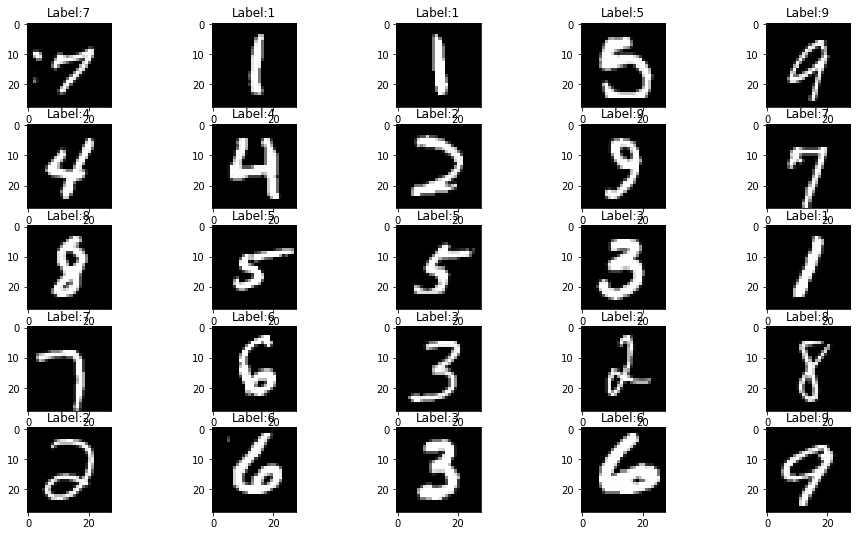

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(16, 9))
for i in range(5):
   for j in range(5):
     k = np.random.randint(0, len(train_dataset), 1)[0]
     im, lab = train_dataset[k]
     #im = 1. - im
     axs[i,j].imshow(im[0], cmap='gray')
     axs[i,j].set_title('Label:' + str(lab))
plt.show()

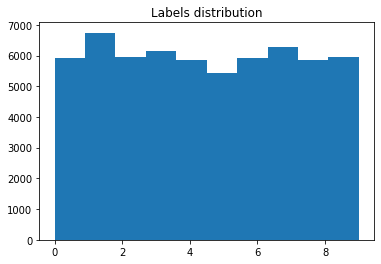

In [16]:
labels = [train_dataset[i][1] for i in range(len(train_dataset))]
plt.title('Labels distribution')
plt.hist(labels, bins=len(set(labels)))
plt.show()

In [17]:
print('Number of images:', len(train_dataset))
print('Number of unique labels:', len(set(labels)))
print('Number of images per label:', len(train_dataset) // len(set(labels)))

Number of images: 60000
Number of unique labels: 10
Number of images per label: 6000


In [5]:
# model hyperparameters
M, k = 3, 2
lambd = 1.
margin = .6

# training hyperparameters
n_epochs = 10
batch_size = 128
lr = 1e-3
log_interval = 100

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

siamese_train_dataset = PairedDataset(train_dataset)
siamese_test_dataset = PairedDataset(test_dataset)

siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [7]:
feature_extractor = FeatureExtractor(M, k)
model = SiameseNet(feature_extractor)

if cuda:
    model.cuda()

criterion = ContrastiveLoss(margin, M, k, lambd)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [8]:
train_losses, val_losses = [], []
for epoch in range(n_epochs):
    scheduler.step()

    train_loss = train_epoch(siamese_train_loader, model, criterion, optimizer, cuda)
    
    val_loss = test_epoch(siamese_test_loader, model, criterion, cuda)
    val_loss /= len(siamese_test_loader)

    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}; Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss, val_loss)
    print(message)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1/10. Train set: Average loss: 0.0127; Validation set: Average loss: 0.0045
Epoch: 2/10. Train set: Average loss: 0.0038; Validation set: Average loss: 0.0029
Epoch: 3/10. Train set: Average loss: 0.0027; Validation set: Average loss: 0.0022
Epoch: 4/10. Train set: Average loss: 0.0019; Validation set: Average loss: 0.0021
Epoch: 5/10. Train set: Average loss: 0.0013; Validation set: Average loss: 0.0028
Epoch: 6/10. Train set: Average loss: 0.0011; Validation set: Average loss: 0.0016
Epoch: 7/10. Train set: Average loss: 0.0009; Validation set: Average loss: 0.0021
Epoch: 8/10. Train set: Average loss: 0.0004; Validation set: Average loss: 0.0012
Epoch: 9/10. Train set: Average loss: 0.0003; Validation set: Average loss: 0.0011
Epoch: 10/10. Train set: Average loss: 0.0002; Validation set: Average loss: 0.0012


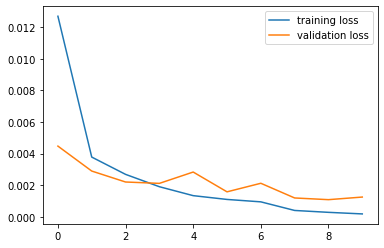

In [9]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.savefig('./figures/losses.png')
#plt.show()

In [10]:
def extract_embeddings(dataloader):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), M, k))
        labels = np.zeros(len(dataloader.dataset))
        l = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            emb = model.get_embedding(images)
            emb = emb.view((emb.size(0), M, k))
            embeddings[k:k+len(images)] = emb.data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            l += len(images)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(train_loader)
test_embeddings, test_labels = extract_embeddings(test_loader)

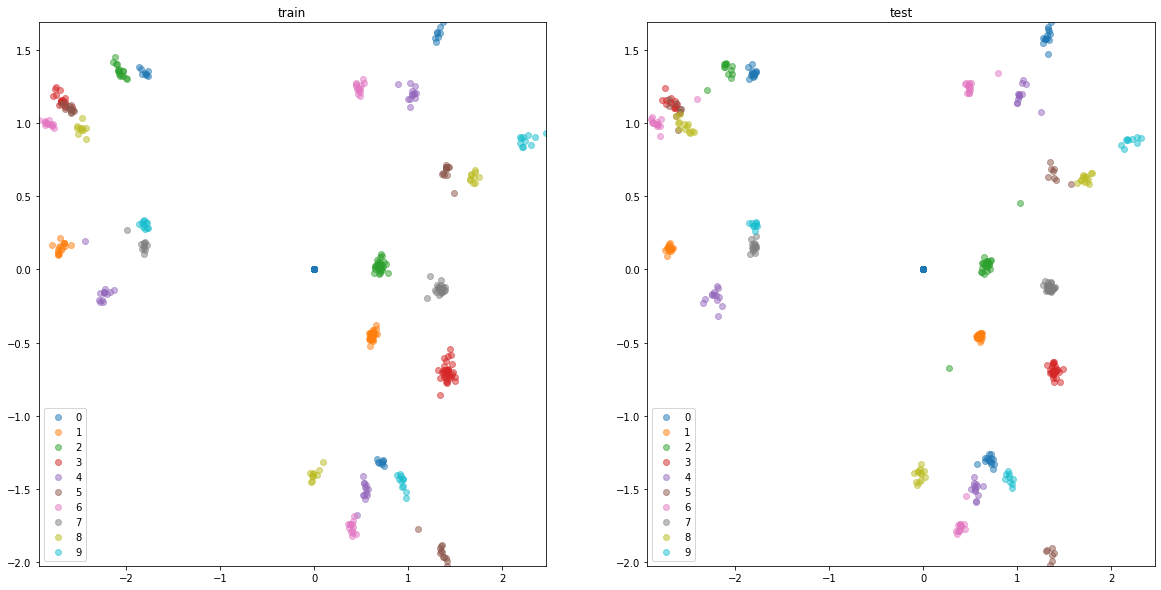

In [11]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
for i in range(10):
    inds = np.where(train_labels==i)[0]
    tmp = train_embeddings[inds,:,:].reshape((-1, 2))
    plt.scatter(tmp[:,0], tmp[:,1], alpha=0.5, label=str(i))
plt.title('train')
plt.legend()
xmin, xmax = np.min(train_embeddings[:,:,0]), np.max(train_embeddings[:,:,0])
ymin, ymax = np.min(train_embeddings[:,:,1]), np.max(train_embeddings[:,:,1])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.subplot(122)
for i in range(10):
    inds = np.where(test_labels==i)[0]
    tmp = test_embeddings[inds,:,:].reshape((-1, 2))
    plt.scatter(tmp[:,0], tmp[:,1], alpha=0.5, label=str(i))
plt.title('test')
plt.legend()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.savefig('./figures/point_cloud_visualization.png')
#plt.show()

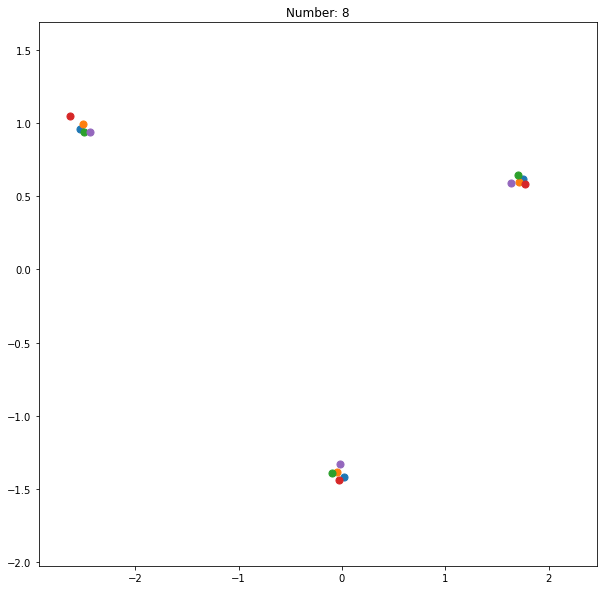

In [13]:
i = 8
inds = np.where(test_labels==i)[0]

plt.figure(figsize=(10, 10))

for j in range(5):
    plt.scatter(test_embeddings[inds[j],:,0], test_embeddings[inds[j],:,1], alpha=1., s=50)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.title('Number: '+str(i))
plt.savefig('./figures/features_visualization.png')
#plt.show()

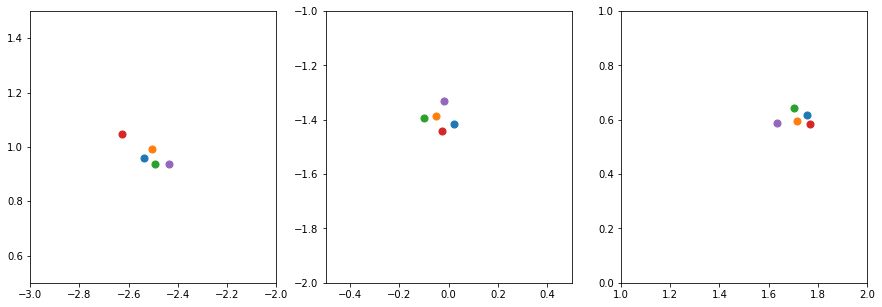

In [14]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

for j in range(5):
    ax1.scatter(test_embeddings[inds[j],:,0], test_embeddings[inds[j],:,1], alpha=1., s=50)
ax1.set_xlim(-3, -2)
ax1.set_ylim(0.5, 1.5)

for j in range(5):
    ax2.scatter(test_embeddings[inds[j],:,0], test_embeddings[inds[j],:,1], alpha=1., s=50)
ax2.set_xlim(-0.5, 0.5)
ax2.set_ylim(-2, -1)

for j in range(5):
    ax3.scatter(test_embeddings[inds[j],:,0], test_embeddings[inds[j],:,1], alpha=1., s=50)
ax3.set_xlim(1, 2)
ax3.set_ylim(0, 1)

plt.savefig('./figures/features_visualization_zoom.png')
#plt.show()